# A proof-of-concept for twitter network analysis
The Google DataLab has outdated versions of (at least) `networkx` and `plotly` installed, so we first need to manually upgrade these (the quickest way, but needs to be done everytime the jupyter instance restarts).

__Caveat__: The Google DataLab runs on `Python 3.5`, so we can't use f-strings (`f"Python {myPythonVersion}"`) which need `Python 3.6` at least.

In [ ]:
!pip install --upgrade networkx

In [ ]:
!pip install --upgrade plotly

In [1]:
# data handling, io
import json
import pandas as pd

# array magic
import numpy as np

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go

# network module(s)
import networkx as nx

# from imports
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot  # for offline use
from typing import Union, Iterable, Generator
from collections import Counter  # how could I NOT know about this

# run plotly offline and initialize notebook plotting
init_notebook_mode(connected=True)

In [2]:
# load historic data
data = pd.read_csv('tw_export.csv', sep='\t')

## Functions

In [3]:
def findMeta(s: str, meta: Union[str, Iterable] = ["@", "#"]) -> dict:
    """Find all metatags in a string and return a set of these metatags."""
    meta = [meta] if isinstance(meta, str) else meta
    return {k: {w for w in s.split(" ") if w.startswith(k)} for k in meta}


def addFollower(graph: nx.Graph, follower: str, mentions: Iterable = []) -> None:
    """Add follower with edges to their mentions."""
    # TODO: check if new nodes with edges to existing nodes overwrite their connections.
    if ((follower != "") or (follower is not None)):
        mentions = [mentions] if isinstance(mentions, str) else mentions
        follower = "@" + follower if not follower.startswith("@") else follower
        if len(mentions):
            graph.add_edges_from(((follower, e) for e in mentions)) # generator expression whoo
        else:
            graph.add_node(follower)

            
def inMostCommon(tags: Iterable, most_common: Iterable) -> bool:
    """Check if at least one of the metatags exists in the most common metatags."""
    for t in tags:
        if t in most_common:
            return True
    return False


def occuranceCounter(contentList: list, mostCommon: int = 10) -> tuple:
    """Returns the labels and the counts of the most common elements in `contentList`.
    Any negative value for `mostCommon` will return the full list.  
    Assumes that `contentList` is sorted.
    
    Return is a tuple of the sorted label and the sorted value list. For the full list a numpy array is created
    """
    if mostCommon > 0:
        return zip(*dict(Counter(contentList).most_common(mostCommon)).items())
    else:  # numpy
        labels, values = zip(*dict(Counter(contentList)).items())
        sort = np.argsort(values)[::-1]  # descending order 
        return np.array(labels)[sort], np.array(values)[sort]
    

## Network

In [4]:
# init graph
twitterGraph = nx.Graph()

# find most common hashtags and mentions
mostCommon = 10  # arbitrary
hashtags = []  # init
mentions = []  # init

for l in data.content:
    metas = findMeta(l)
    hashtags.extend(metas['#'])
    mentions.extend(metas['@'])

hashtags = sorted(hashtags)
mentions = sorted(mentions)

hashLabels, hashValues = occuranceCounter(hashtags, mostCommon=mostCommon)
mentLabels, mentValues = occuranceCounter(mentions, mostCommon=mostCommon)


### Investigating most common mentions

Text(0.5,0,'$\\#$ of mentions')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



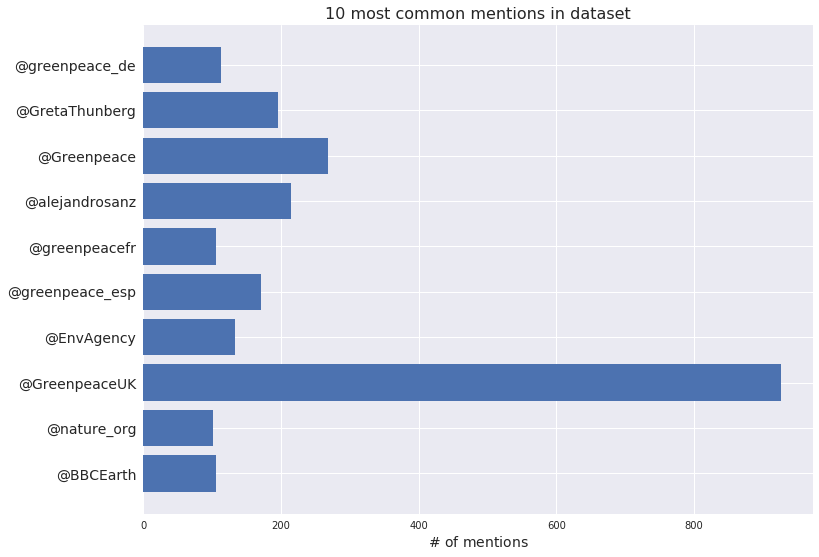

In [5]:
# figure setup
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)

# barplot
bar = ax.barh(mentLabels[::-1], mentValues[::-1])

# cosmetics 
yticks = ax.set_yticklabels(mentLabels[::-1], fontdict={'fontsize': 14})

# description
ax.set_title("{} most common mentions in dataset".format(mostCommon), fontsize=16)
ax.set_xlabel("$\#$ of mentions", fontdict={'fontsize': 14})

### Creating a network graph for the most common participants in 

In [6]:
for f, c in zip(data['url'], data['content']):
    f = f.split('/')[3]  # get the handle
    metas = findMeta(c)
    mentions = metas['@']
    tags = metas['#']
    if inMostCommon([*mentions, f], mentLabels):
        addFollower(twitterGraph, f, mentions)

In [7]:
sizes = {l: v for l, v in zip(mentLabels, mentValues)}
sizesList = [sizes.get(m, 10) for m in twitterGraph.nodes]
printLabels = {n: '' if n not in mentLabels else n for n in twitterGraph.nodes}

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



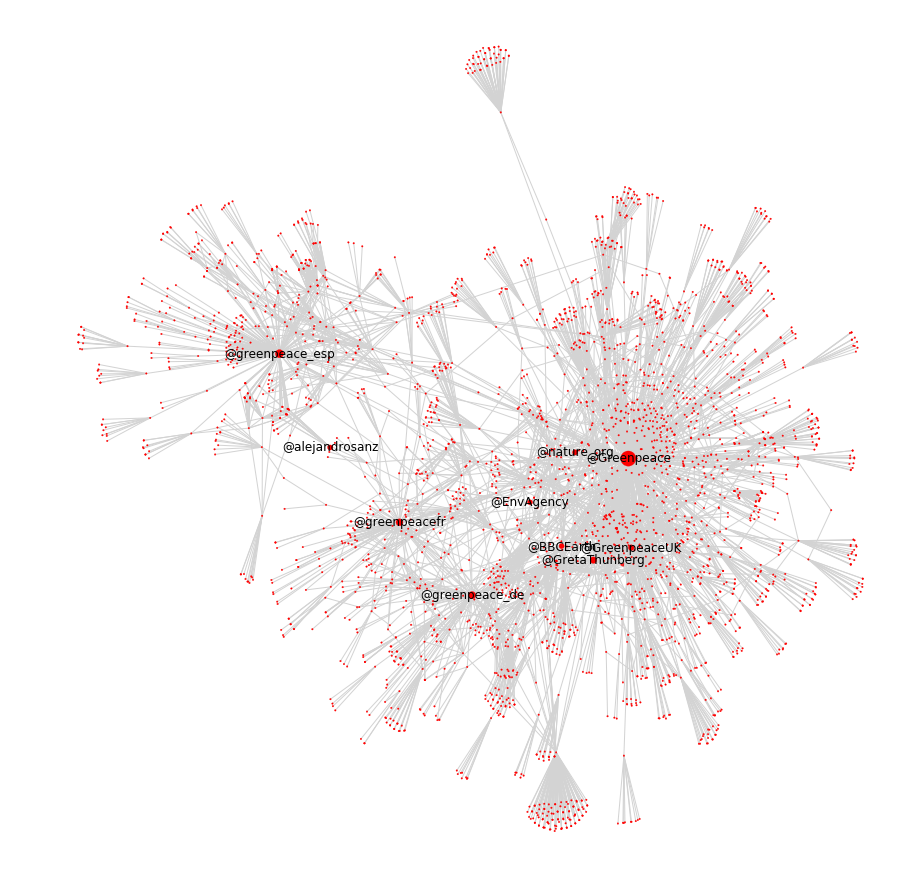

In [9]:
plt.figure(figsize=(12, 12))
nx.draw_spring(twitterGraph, node_shape='.', node_size=sizesList, with_labels=True, 
               font_size=12, labels=printLabels, edge_color="#d3d3d3" )
# plt.savefig("testfig.svg")

## Creating a network graph for most active twitterers

In [4]:
# init graph
mostActiveTwitterGraph = nx.Graph()

# find most common hashtags and mentions
mostCommon = 20  # arbitrary
posters = ["@{}".format(l.split('/')[3]) for l in data.url]  # init

# hashtags = sorted(hashtags)
posters = sorted(posters)

posterLabels, posterValues = occuranceCounter(posters, mostCommon=mostCommon)


## Generate Graph structure

In [5]:
for p, c in zip(data['url'], data['content']):
    p = "@{}".format(p.split('/')[3])  # get the handle
    metas = findMeta(c)
    mentions = metas['@']
    # tags = metas['#']
    if inMostCommon([p], posterLabels):  # if poster is in most active posters group add the node
        addFollower(mostActiveTwitterGraph, p, mentions)

# remove self loops
mostActiveTwitterGraph.remove_edges_from(mostActiveTwitterGraph.selfloop_edges())

## Add attributes to nodes

In [6]:
# create list of nodesizes
mostCommonTweeters = {h:v for h, v in zip(posterLabels, posterValues)}
sizes = [mostCommonTweeters.get(m, 5) for m in mostActiveTwitterGraph.nodes]
printLabels = {n: '' if n not in posterLabels else n for n in mostActiveTwitterGraph.nodes}

/home/corvus/code/GPI-projects/gpi/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



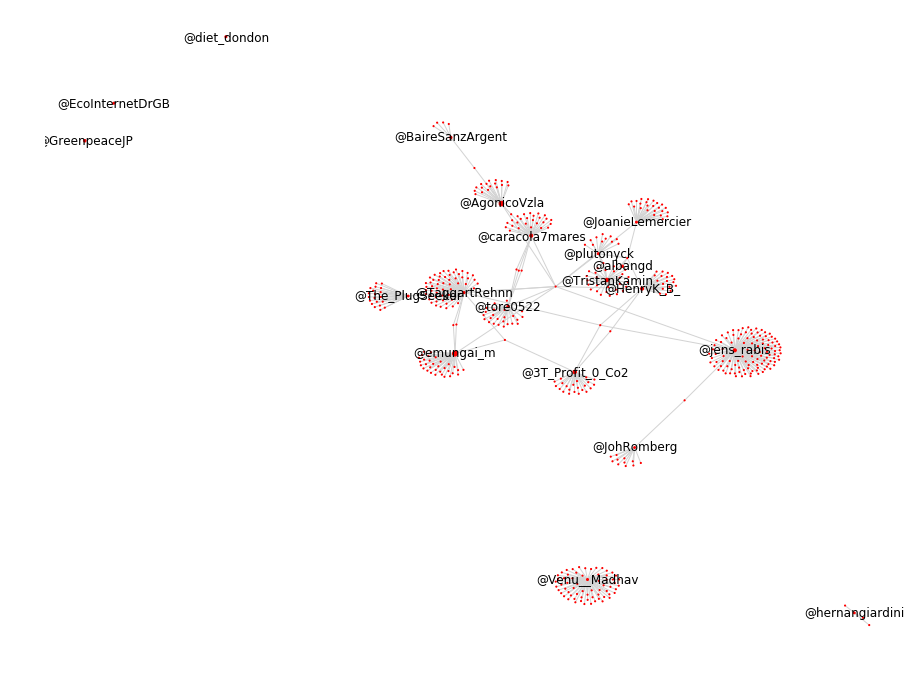

In [7]:
plt.figure(figsize=(12, 9))
nx.draw_spring(mostActiveTwitterGraph, node_shape='.', node_size=sizes, with_labels=True, 
               font_size=12, labels=printLabels, edge_color="#d3d3d3" )
# plt.savefig("mostActiveTwittererers.svg")

# A test for interactivity with plotly

In [8]:
# since we don't have coordinates for the nodes, they need to be created
# the `k` parameter controls the distance of nodes; default is 1/sqrt(len(nodes))
pos = nx.drawing.layout.spring_layout(mostActiveTwitterGraph,
                                      k=2/np.sqrt(len(mostActiveTwitterGraph.nodes)))

In [11]:
# creating the trace of edges
edge_trace = go.Scatter(x=[],  # initially empty
                        y=[],  # ^
                        line={'width': 0.5, 'color': '#888'},
                        hoverinfo='none',  # no hoverinfo for edges
                        mode='lines')  # draw lines in Scatter instance

# iterate across all edges, get their node positions and add them to the edge trace
for edge in mostActiveTwitterGraph.edges():
    b, e = edge  # beginning and end of edge
    x0, y0 = pos[b]
    x1, y1 = pos[e]
    edge_trace['x'] += (x0, x1, None)  # NOTE: I suspect the `None` is needed so you only connect two nodes
    edge_trace['y'] += (y0, y1, None)

node_trace = go.Scatter(x=[],
                        y=[],
                        text=[],
                        mode='markers',
                        hoverinfo='text',
                        marker={'showscale': True,
                                'colorscale': 'Viridis',
                                # reversescale=True,
                                'color': [],
                                # 'size': 5
                                'size': sizes,
                                'sizemode': 'area',
                                'sizeref': 2 * max(sizes)/(40.**2),
                                'sizemin': 3,
                                'colorbar': {'thickness': 15,
                                            'title': 'Node Connections',
                                            'xanchor': 'left',
                                            'titleside': 'right'
                                            },
                                'line': {'width': 0.1}
                               })

# iterate over all nodes and add the node's location to the node_trace graph
for node in mostActiveTwitterGraph.nodes():
    x, y = pos[node]
    node_trace['x'] += x,  # tuple magic
    node_trace['y'] += y,  # ^


# iterate over all nodes and their adjacencies, count the adjacencies
for node, adjacencies in mostActiveTwitterGraph.adjacency():
    adjLen = len(adjacencies)
    node_trace['marker']['color'] += adjLen,
    posts = mostCommonTweeters.get(node)
    posts = "<br>{} posts".format(posts) if posts is not None else ""
    node_info = "{}{}<br>{} connection(s)".format(node, posts, adjLen)
    node_trace['text'] += node_info,


# manually create the legend for the bubble-size
bubble_sizes = [1, 50, 100]
bubble_legend = go.Scatter(x=[-.5, -0.3, -0.1][::-1],  # 3 values for scale,
                           y=[1.2]*3,  # ^,
                           text="{} Post,{} Posts,{} Posts".format(*bubble_sizes).split(","),
                           textfont={"size": 14},
                           textposition="bottom center",
                           mode="markers+text",
                           marker={'color': 'gray',
                                   'size': bubble_sizes,
                                   'sizemode': 'area',
                                   'sizeref': 2 * max(sizes)/(40.**2),
                                   'sizemin': 3,
                                'line': {'width': 0.5}})

In [12]:
axislabels = {l: False for l in ["showgrid", "zeroline", "showticklabels"]}
layout = go.Layout(title=("Most active {} Tweeters and their interaction network"
                          " in a dataset of size {} tweets".format(len(mostCommonTweeters), len(data))),
                   titlefont={"size": 16},
                   showlegend=False,
                   hovermode="closest",
                   width=900,
                   height=900,
                   margin={"b": 20, "l": 5, "r": 5, "t": 40},
                   xaxis=axislabels,
                   yaxis=axislabels)

fig = go.Figure(data=[edge_trace, node_trace, bubble_legend], layout=layout)

iplot(fig) #, filename='networkx')
